In [1]:
import math 
import os
import re
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx


from concurrent.futures import ThreadPoolExecutor
import logging
from os import listdir
from os.path import isfile, join
from random import sample
from scipy.spatial import distance
from scipy.cluster import hierarchy as hc
from scipy.linalg import sqrtm, block_diag, pinvh, eigh
from numpy.linalg import inv, pinv
from numpy.random import normal, poisson, randint
from numpy import diagflat, eye, fill_diagonal, diag, sqrt, min, max
from sklearn.utils import resample

from aux_functions import *
from utls import *

In [2]:
def process_graph(size):
    graph = genWG(d=d, p11=.8, p22=.7, p12=.3, lam11=20, lam22=15, lam12=6)
    return graph + np.ones((d, d))

# Experiments

In [3]:
#Generate data

d = 8 #matrix size
pop_size = 800  # размер популяции


#Generate regularized adjacency matrices
population_graphs = [] 
with ThreadPoolExecutor() as executor:
    population_graphs = list(executor.map(lambda _: process_graph(size = d), range(pop_size)))
       

#Create projected and inverted GLs
population = [] 

U = GenONbasisVec(d) #ON basis for projection of GL
for p in population_graphs:
    population.append(genGLFast(p, U)) #compute and project GL

In [4]:
#Compute ture distribution
fm = Fbarycenter(population) #initial point to make the computation faster
bw = Wbarycenter(population, init = fm, verbose = True, max_iterations = 10)  # вычисление барицентра

1 0.1378375919123444
2 0.001969793302613789
3 0.00012711400296428418
Success! Iterations number: 3


In [5]:
#Initiate resampling parameters
n = 10 #sample size
N = 10 #number of bootstrap/asymptotic curves
M = 10 #number of iterations withn one bootstrap/asymptotic trial

In [6]:
#True distribution

dist_true = []
for _ in range(M):
    sub_population = subsmple(population, n, repl = False)
    M_emp  = Fbarycenter(sub_population)
    bw_emp =  Wbarycenter(sub_population, init = M_emp)
    dist_true.append(BW(bw_emp, bw) * np.sqrt(n))
    
np.save('bw_true_d{0}_n{1}_M{2}_L_proj.npy'.format(d, n, M),dist_true)

In [7]:
#bootstrap
stat_boot  = bootstrap(population, size = n, iters = M, boot_samples = N)

In [8]:

#asymptotic distribution
stat_asymp = asymptotic_statistics(population, size = n, iters = M, boot_samples = N)

In [9]:
x_grd = find_grid(dist_true, stat_boot, stat_asymp, steps = 1000)

ecdfs_boot  = compute_ecdfs(stat_boot, x_grd)
ecdfs_asymp = compute_ecdfs(stat_asymp, x_grd)
ecdf_true = ecdf_on_grid(dist_true, x_grd)

m_boot, v_boot = compute_KS_stat(ecdf_true, ecdfs_boot)
m_asmp, v_asmp = compute_KS_stat(ecdf_true, ecdfs_asymp)


print(m_boot, v_boot)
print(m_asmp, v_asmp) 

0.4800000000000001 0.015599999999999998
0.43 0.0121


In [10]:
KS_var_asm = ceil_to_decimals(v_asmp , 3)
KS_mean_asm = ceil_to_decimals(m_asmp, 3)
KS_var_boot = ceil_to_decimals(v_boot, 3)  
KS_mean_boot = ceil_to_decimals(m_boot, 3)  

# Plots

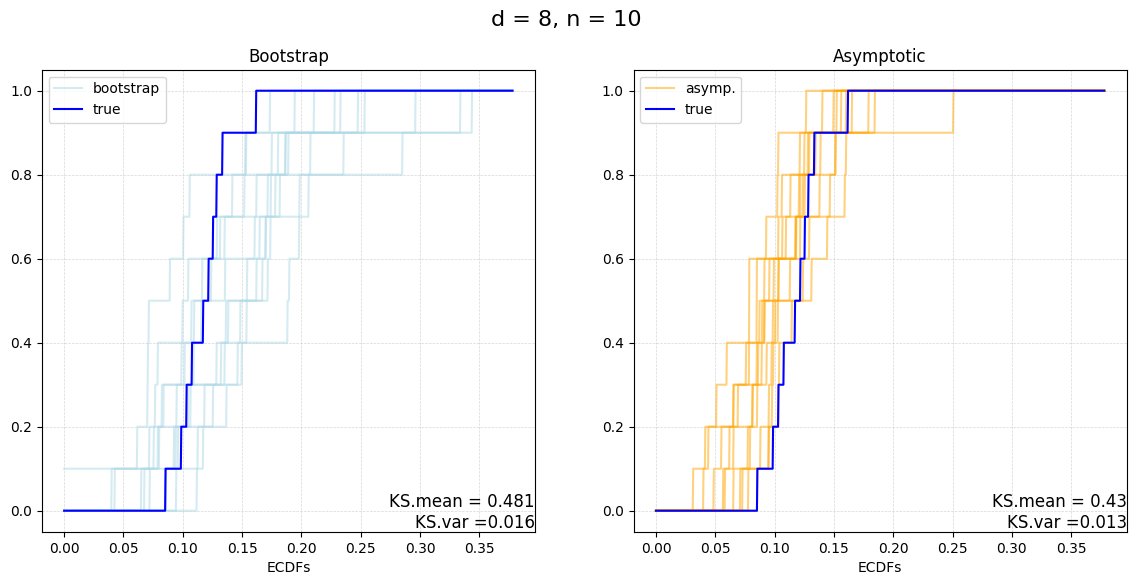

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))


for i in range(len(ecdfs_boot)):  
    if (i == 1):
        axes[0].plot(x_grd, ecdfs_boot[i], c='lightblue', alpha = .5, label='bootstrap')
    else:
        axes[0].plot(x_grd, ecdfs_boot[i], c = 'lightblue', alpha = .5)
        

axes[0].plot(x_grd, ecdf_true, c = 'blue', label='true', lw = 1.5)

axes[0].set_title("Bootstrap")
axes[0].set_xlabel("ECDFs")
# axes[0].set_ylabel("sin(x)")
axes[0].legend(loc='best')
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)  # Add pale grid
xlim1 = axes[0].get_xlim()
ylim1 = axes[0].get_ylim()

# Place text in the lower-right corner of the first plot
axes[0].text(xlim1[1], ylim1[0], "KS.mean = {0}\nKS.var ={1}".format(KS_mean_boot, KS_var_boot), fontsize=12, color='black', 
             ha='right', va='bottom')


for i in range(len(ecdfs_asymp)):  
    if (i == len(ecdfs_asymp) - 1):
        axes[1].plot(x_grd, ecdfs_asymp[i], c='orange', alpha = .5, label='asymp.')
    else:
        axes[1].plot(x_grd, ecdfs_asymp[i], c = 'orange', alpha = .5)

axes[1].plot(x_grd, ecdf_true, c = 'blue', label='true', lw = 1.5)
axes[1].set_title("Asymptotic")
axes[1].set_xlabel("ECDFs")
# axes[0].set_ylabel("sin(x)")
axes[1].legend(loc='best')
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)  # Add pale grid

# Place text in the lower-right corner of the first plot
axes[1].text(xlim1[1], ylim1[0], "KS.mean = {0}\nKS.var ={1}".format(KS_mean_asm, KS_var_asm), fontsize=12, color='black', 
             ha='right', va='bottom')



fig.suptitle("d = {0}, n = {1}".format(d, n), fontsize=16)

plt.savefig("boot_cdfs_d={0}_n={1}_L_proj.png".format(d, n), dpi=300)